<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/statistical_arbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime

def get_ranking(market:str='ks'):
  url = "https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0"
  if market == 'ks': 
    url = "https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0"
  elif market == 'kq':
    url = "https://finance.naver.com/sise/sise_market_sum.nhn?sosok=1"
  dic = []
  result = requests.get(url, headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'})
  bs_obj = BeautifulSoup(result.content, "html.parser")
  tr = bs_obj.find_all("tr", {'onmouseover':"mouseOver(this)"})

  for i in range(0,50):
    dic.append(tr[i].find_all('a')[0]['href'][-6:])

  return dic

In [2]:
def get_related(code:str='005930'):
  url = 'https://finance.naver.com/item/main.nhn?code=' + code
  result = requests.get(url, headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'})
  bs_obj = BeautifulSoup(result.content, "html.parser")
  th = bs_obj.find_all("th", {'scope':"col"})
  th = [x.get_text() for x in th][-12:-7]
  elements = [x[-6:] for x in th]
  return elements

get_related()

['005930', '000660', '240810', '058470', '357780']

In [3]:
class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def page_to_df(self, page):
    url = "https://finance.naver.com/item/sise_day.nhn?code=" + self.code + "&page=" + str(page)
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    tr = bs_obj.find_all("tr", {'onmouseover':'mouseOver(this)', 'onmouseout':"mouseOut(this)"})
    data_dict = {}
    for i in range(10):
      try: 
        spans = tr[i].find_all('span')
        lines = [span.get_text() for span in spans]
        lines = list(map(lambda x: x.replace(',',''), lines))

        objdate = datetime.datetime.strptime(lines[0], '%Y.%m.%d')
        data_dict[objdate] = lines[1:]
      except:
        break
      
    df = pd.DataFrame.from_dict(data_dict).transpose()
    df.columns = ['Close','_','Open',
                        'High','Low','Volume']
    df = df.drop(columns="_")

    return df

  def get_data(self, start_page:int=1, end_page:int=26):
    df = self.page_to_df(start_page)
    # max 9999
    # 1 page = 10 days
    for i in range(start_page, end_page): 
      try: 
        if (any(self.page_to_df(i).index != self.page_to_df(i-1).index)):
          df = df.append(self.page_to_df(i))
          print('.', end = '')
          if (i%100==0):
            print(i)
        else:
          break
      except:
        df = df.append(self.page_to_df(i))
    df = df.sort_index(axis = 0) 
    for i in ['Close', 'Open', 'High', 'Low', 'Volume']:
      df[i] = df[i].astype(int)
    return df    

In [14]:
# codes = get_related('035420')
# codes = ['226490','229200'] kospi & kosdaq ==> 의미없음

# codes = ['138920', '500013', '137610'] ==> 의미있음: 콩선물, 옥수수, 농산물


codes = ['138920', '500013', '137610']

In [15]:
dic = {}
start_page = 2
end_page = 100

for i in codes:
  stock = Stock(i)
  dic[i] = stock.get_data(start_page, end_page)
  print()

..................................................................................................
..................................................................................................
..................................................................................................


In [16]:
valid = ((end_page - start_page) + 1) * 10

for i in codes:
  if (len(dic[i]['Close']) != valid):
    codes.remove(i)

In [17]:
def norm(x):
  norm = np.linalg.norm(x)
  return np.round(x/norm, 16)

In [18]:
norm_dic = {}

for i in codes:
  norm_dic[i] = norm(dic[i]['Close'])

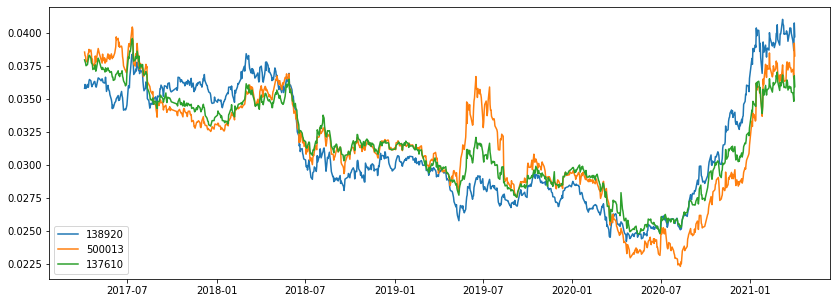

In [19]:
from matplotlib import pyplot as plt

plt.subplots(figsize=(14, 5))
for i in codes:
  plt.plot(norm_dic[i])

plt.legend(codes)
plt.show()

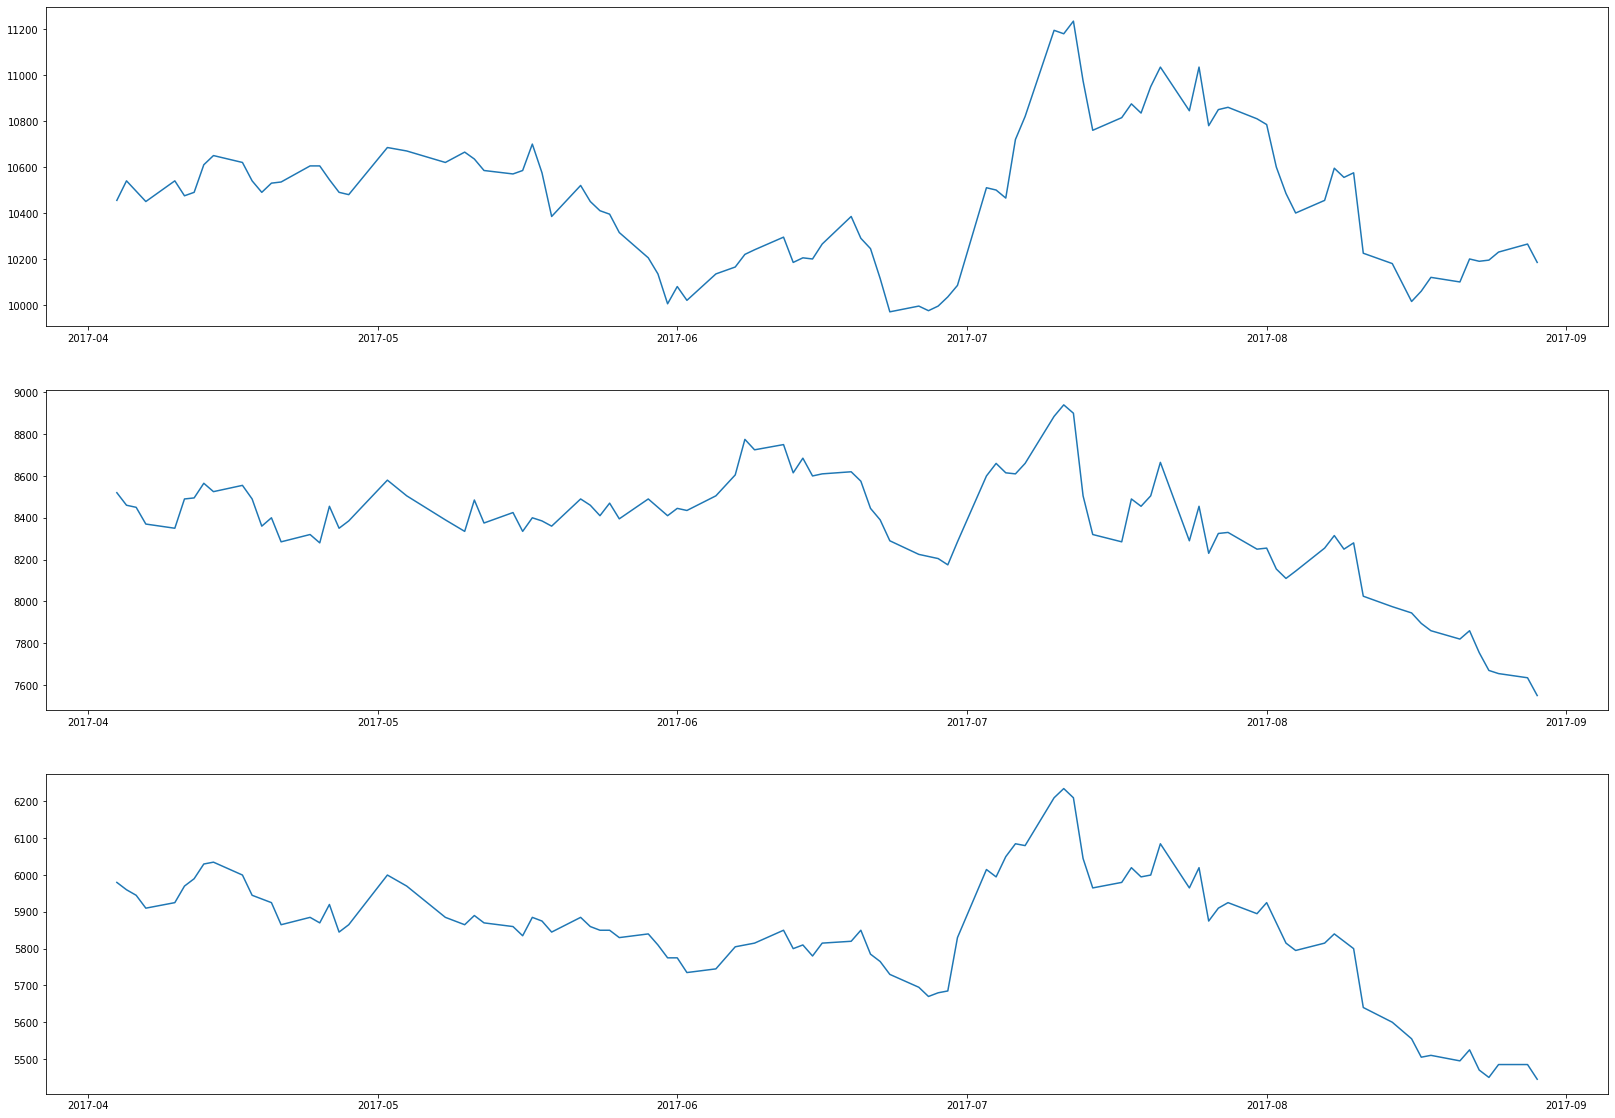

In [20]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(len(codes), figsize=(28,20))
for i in range(0,len(codes)):
  axs[i].plot(dic[codes[i]]['Close'][:100])
plt.show()